# Installing / Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from pandas import to_datetime
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

# grid search sarima hyperparameters
from math import sqrt

import multiprocessing
multiprocessing.set_start_method('spawn', True)
from multiprocessing import cpu_count

from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

In [3]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data Exploration

In [4]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [5]:
Daily_data.set_index('date', inplace = True)
Daily_data.isna().any()

Inquiries_NonStat    False
Inquiries_Stat        True
dtype: bool

In [6]:
Daily_data.describe()

,Inquiries_NonStat,Inquiries_Stat
count,2100.000000,2094.000000
mean,14234.188571,0.998492
std,5816.090211,0.328633
min,96.000000,0.038536
25%,9733.750000,0.599834
50%,13863.500000,1.145044
75%,19307.000000,1.233318
max,30619.000000,2.227288


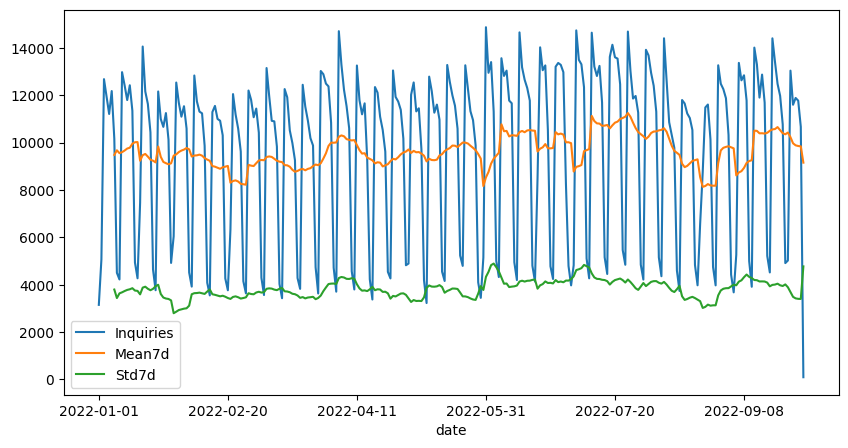

In [7]:
Daily_data.loc['2022-01-01' :]['Inquiries_NonStat'].plot(label='Inquiries')
Daily_data.loc['2022-01-01' :].rolling(window=7).mean()['Inquiries_NonStat'].plot(label='Mean7d')
Daily_data.loc['2022-01-01' :].rolling(window=7).std()['Inquiries_NonStat'].plot(label='Std7d')
plt.legend()

In [17]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')
    print ()
    print (dfoutput)
    print ()
    
adf_test(Daily_data['Inquiries_NonStat'].dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
    print ()
    print (kpss_output)
    print ()
kpss_test(Daily_data['Inquiries_NonStat'].dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -1.971946
p-value                           0.299008
#Lags Used                       26.000000
Number of Observations Used    2073.000000
Critical Value (1%)              -3.433508
Critical Value (5%)              -2.862935
Critical Value (10%)             -2.567513
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.122761
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



ADF test & KPSS test --> Non-Stationary

# Train-Test split

In [18]:
#Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)

train_df = Daily_data.iloc[:1680]
test_df  = Daily_data.iloc[1679:]
train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

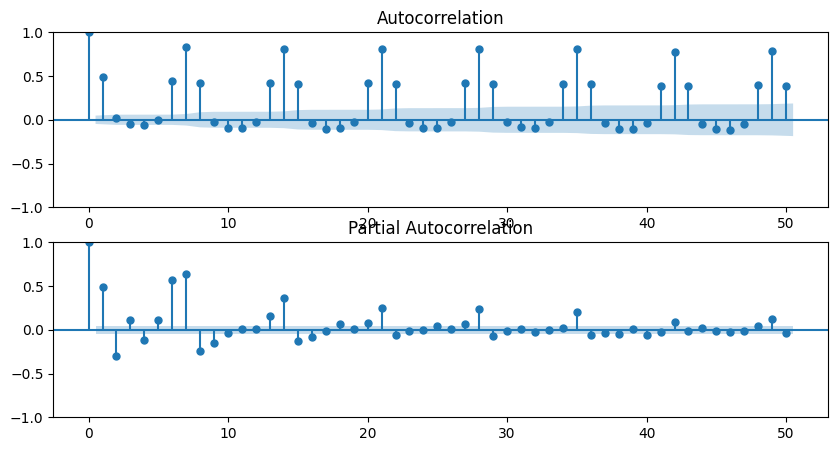

In [19]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train_df, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_df, lags=50, ax=ax[1])
plt.show()

p and P both equal 1 (significant positive spikes in ACF and PACF plots)
d and D both equal 1 (first difference and seasonal difference)
q and Q both equal 0 & 1 (no significant negative spikes)
s equal to 7 (weekly seasonal component)

Optimization terminated successfully.
         Current function value: 9.198423
         Iterations: 3
         Function evaluations: 149


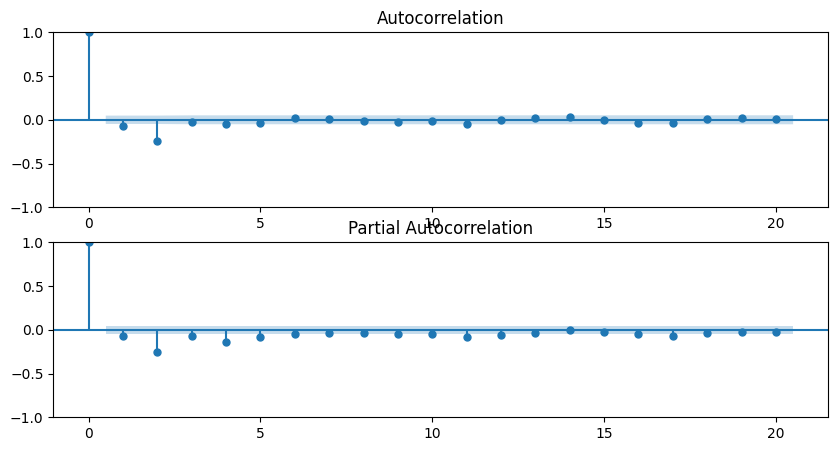

In [20]:
filterwarnings("ignore")
model = sm.tsa.statespace.SARIMAX(train_df, order=(1,1,0), seasonal_order=(1,1,1,7)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

In [27]:
filterwarnings("ignore")
model = sm.tsa.statespace.SARIMAX(train_df, order=(1,1,0), seasonal_order=(1,1,1,7)).fit(max_iter=50, method='powell')
res = model.resid

y_hat = model.predict(len(train_df), len(train_df))
y_hat
rmse = sqrt(mean_squared_error(test_df[1:2], y_hat))
rmse, model.aic, model.bic

Optimization terminated successfully.
         Current function value: 9.198423
         Iterations: 3
         Function evaluations: 149


(177.70136386320155, 30914.70068578767, 30936.38778896225)

In [21]:
from tabulate import tabulate

# Create an empty table
table = []

# Add the column names
table.append(["param", "param_seasonal", "AIC"])

import itertools
#set parameter range
p = range(1,3)
q = range(1,3)
d = range(1,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_df,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            #y_hat = results.predict(len(train_df), len(train_df))
            #rmse = sqrt(mean_squared_error(test_df, y_hat))
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            table.append([param, param_seasonal, results.aic])
        except:
            continue


Optimization terminated successfully.
         Current function value: 9.122233
         Iterations: 5
         Function evaluations: 289
SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:30660.701308723743
Optimization terminated successfully.
         Current function value: 9.122804
         Iterations: 4
         Function evaluations: 281
SARIMA(1, 1, 1),(1, 1, 2, 7) - AIC:30664.619943527374
Optimization terminated successfully.
         Current function value: 9.122013
         Iterations: 5
         Function evaluations: 358
SARIMA(1, 1, 1),(2, 1, 1, 7) - AIC:30661.9646762814
Optimization terminated successfully.
         Current function value: 9.125106
         Iterations: 4
         Function evaluations: 332
SARIMA(1, 1, 1),(2, 1, 2, 7) - AIC:30674.355448961323
Optimization terminated successfully.
         Current function value: 9.131334
         Iterations: 3
         Function evaluations: 206
SARIMA(1, 1, 2),(1, 1, 1, 7) - AIC:30693.28298846846
Optimization terminated successfully.
     

In [22]:
table1 = tabulate(table)
print(tabulate(table))

---------  --------------  ------------------
param      param_seasonal  AIC
(1, 1, 1)  (1, 1, 1, 7)    30660.701308723743
(1, 1, 1)  (1, 1, 2, 7)    30664.619943527374
(1, 1, 1)  (2, 1, 1, 7)    30661.9646762814
(1, 1, 1)  (2, 1, 2, 7)    30674.355448961323
(1, 1, 2)  (1, 1, 1, 7)    30693.28298846846
(1, 1, 2)  (1, 1, 2, 7)    30695.74544867496
(1, 1, 2)  (2, 1, 1, 7)    30695.030925637904
(1, 1, 2)  (2, 1, 2, 7)    30697.36316968935
(2, 1, 1)  (1, 1, 1, 7)    30639.7172267221
(2, 1, 1)  (1, 1, 2, 7)    30649.14080045049
(2, 1, 1)  (2, 1, 1, 7)    30641.69449508105
(2, 1, 1)  (2, 1, 2, 7)    30643.716895725353
(2, 1, 2)  (1, 1, 1, 7)    30661.931109925084
(2, 1, 2)  (1, 1, 2, 7)    30664.22239912809
(2, 1, 2)  (2, 1, 1, 7)    30664.966100616242
(2, 1, 2)  (2, 1, 2, 7)    30666.46681082327
---------  --------------  ------------------


In [68]:
scores_data = np.array(table)
df = pd.DataFrame(table)
df.columns=df.iloc[0] 
df = df.drop(index=0,axis=0)
minAIC = df['AIC'].min()
df[df['AIC'] == minAIC]

,param,param_seasonal,AIC
9,"(2, 1, 1)","(1, 1, 1, 7)",30639.717227


# SARIMA(2, 1, 1)	(1, 1, 1, 7)	AIC --> 30639.717227

## Lead time = 0 & single - step ahead

In [195]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = sm.tsa.statespace.SARIMAX(train, order=(2,1,1),
                                            seasonal_order = (1,1,1,7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = 1)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-1
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 9.115670
         Iterations: 7
         Function evaluations: 481
Optimization terminated successfully.
         Current function value: 9.115392
         Iterations: 7
         Function evaluations: 481
Optimization terminated successfully.
         Current function value: 9.115114
         Iterations: 7
         Function evaluations: 481
Optimization terminated successfully.
         Current function value: 9.114851
         Iterations: 7
         Function evaluations: 481
Optimization terminated successfully.
         Current function value: 9.114648
         Iterations: 7
         Function evaluations: 481
Optimization terminated successfully.
         Current function value: 9.114370
         Iterations: 7
         Function evaluations: 481
Optimization terminated successfully.
         Current function value: 9.114094
         Iterations: 7
         Function evaluations: 481
Optimization terminated successful

In [231]:
test_df['Predictions'] = predictions
test_df['Error'] = rmse_list
RMSE_single = test_df['Error'].mean()
test_df

,Inquiries_NonStat,Predictions,RMSE,Error
date,,,,
2021-08-07,5879.0,5754.177185,124.822815,124.822815
2021-08-08,4960.0,5100.844111,140.844111,140.844111
2021-08-09,14917.0,14396.127889,520.872111,520.872111
2021-08-10,13359.0,14501.363880,1142.363880,1142.363880
2021-08-11,13114.0,13190.489801,76.489801,76.489801
...,...,...,...,...
2022-09-26,13039.0,12640.451670,398.548330,398.548330
2022-09-27,11598.0,13255.581226,1657.581226,1657.581226
2022-09-28,11886.0,11788.328826,97.671174,97.671174


In [239]:
test_df = test_df.drop(columns='RMSE')

In [233]:
RMSE_single

757.5540860550041

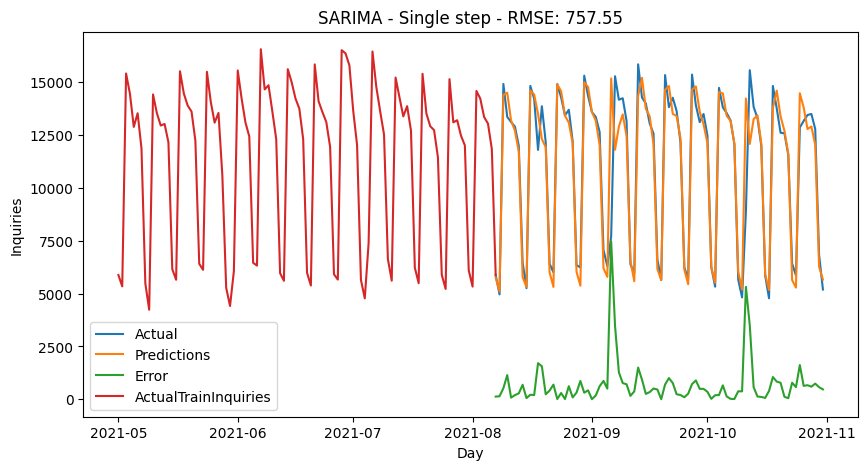

In [241]:
plt.title('SARIMA - Single step - RMSE: 757.55')
plt.plot(test_df[:'2021-10-31'], label = ['Actual','Predictions','Error'])
plt.plot(train_df['2021-05-01':], label = 'ActualTrainInquiries')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()
